In [4]:
from keras import models, layers, preprocessing
from scipy.io.wavfile import read as wavread
from scipy.signal import decimate
from copy import deepcopy
from tqdm import tqdm
import os

%pylab inline
import random as pyrandom

Populating the interactive namespace from numpy and matplotlib


## Control variables

In [5]:
max_sequences = 100  # Limit data to n sequences for processing ease
seq_len = 20*1000  # 4 seconds
sampling_rate = 8*1000  # 8k Hz which is what wiki tells me is the telephone rate
data_dim = 2  # mono channel
train_fraction = 0.7
max_contiguous_drop = seq_len//4  # What length can be dropped max?
# This is akin to the noise ratio you expect. //2 gives you 0.5% of the conversation
# Can be blacked out due to noise
n_corruption_iterations = 10  # Each seq get's how many corruptions?

## Data Formatting

In [7]:
data = []
for fl in sorted(os.listdir('raw_recordings/'), reverse=True):
    path = os.path.join('raw_recordings/', fl)
    if 'part' not in fl and 'wav' in fl:
        datarate, audio = wavread(path)
        same_channels = 'SAME AUDIO' if all(audio[:0] == audio[:1]) else 'MultiChannel'
        print('{:,}Hz {} {} {}'.format(datarate, audio.shape, same_channels, path))
        audio = audio[:,0]
        # -------------------resampling
        while True:
            factor = int(min(10, datarate / sampling_rate))
            datarate /= factor
            if factor <= 1:
                break
            audio = decimate(audio, factor, zero_phase=True)
        sampling_rate = datarate
        print('{:,}Hz {} {} {}'.format(sampling_rate, audio.shape, same_channels, path))
        # -------------------------
        padding_length = seq_len - (audio.shape[0] - (int(audio.shape[0] / seq_len) * seq_len))
        padding = np.zeros(padding_length)
        padded = np.concatenate([audio, padding])
        n_seq = int(padded.shape[0] / seq_len)
        padded = padded.reshape((n_seq, seq_len))
        data.append(padded)
data = list(np.concatenate(data))
print('Shuffling data sequences...')
pyrandom.shuffle(data)
data = [[(float(i), float(i)) for i in seq] for seq in tqdm(data[:max_sequences])]

48,000Hz (110645254, 2) SAME AUDIO raw_recordings/Beowulf - Audio Book-wA0MmqzIGfU.wav


  0%|          | 0/100 [00:00<?, ?it/s]

8,000.0Hz (18440876,) SAME AUDIO raw_recordings/Beowulf - Audio Book-wA0MmqzIGfU.wav
Shuffling data sequences...


100%|██████████| 100/100 [00:00<00:00, 152.82it/s]


## Corrupt audio to make input data

In [25]:
pure, corrupted = [], []
with tqdm(total=len(data)*n_corruption_iterations) as pbar:
    for seq in (data):
        out = seq
        for _ in range(n_corruption_iterations):
            inp = deepcopy(out)
            o = deepcopy(out)
            # ------------------
            start = int(np.random.random()*len(o))
            end = start + int(np.random.random()*max_contiguous_drop)
            end = min(len(o), end)  # Don't overshoot the sequence
            for i in range(start, end):
                inp[i] = (0, 0)
            # ---------------------
            pure.append([i for i in o])
            corrupted.append([i for i in inp])
            pbar.update(1)

100%|██████████| 1000/1000 [02:06<00:00,  8.17it/s]


In [26]:
inp, out = np.array(corrupted), np.array(pure)
del(pure)
del(corrupted)
inp.shape, out.shape

((1000, 20000, 2), (1000, 20000, 2))

## Train Test splits

In [27]:
mask = np.random.random(inp.shape[0]) < train_fraction
train_out, test_out = out[mask], out[~mask]
train_inp, test_inp = inp[mask], inp[~mask]

In [28]:
print(train_inp.shape, train_out.shape, test_inp.shape, test_out.shape)
train_inp.dtype, test_inp.dtype, test_inp.dtype, test_out.dtype

(691, 20000, 2) (691, 20000, 2) (309, 20000, 2) (309, 20000, 2)


(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

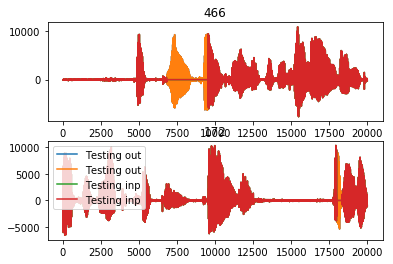

In [32]:
plt.subplots()

plt.subplot(211)
no = int(pyrandom.random()*len(train_out))
plt.plot(train_out[no], label='Training out')
plt.plot(train_inp[no], label='Training inp')
plt.title(str(no))


plt.subplot(212)
no = int(pyrandom.random()*len(test_out))
plt.plot(test_out[no], label='Testing out')
plt.plot(test_inp[no], label='Testing inp')
plt.title(str(no))

plt.legend()

## Model construction

In [35]:
rnn, activation, dropout = layers.LSTM, layers.Activation, layers.Dropout
rnn = layers.GRU

model = models.Sequential()

model.add(rnn(2, input_shape=(seq_len, data_dim), return_sequences=True))
model.add(dropout(0.1))
model.add(activation('relu'))

model.add(rnn(data_dim, return_sequences=True))
model.add(activation('sigmoid'))

model.compile('sgd', 'mse', ['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 20000, 2)          30        
_________________________________________________________________
dropout_4 (Dropout)          (None, 20000, 2)          0         
_________________________________________________________________
activation_7 (Activation)    (None, 20000, 2)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 20000, 2)          30        
_________________________________________________________________
activation_8 (Activation)    (None, 20000, 2)          0         
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


## Model training

In [ ]:
model.fit(train_inp, train_out, validation_data=(test_inp, test_out))

Train on 691 samples, validate on 309 samples
Epoch 1/10
691/691 [==============================] - 103s - loss: 2126123.0861 - acc: 0.9998 - val_loss: 2124286.9721 - val_acc: 1.0000
Epoch 2/10
192/691 [=======>......................] - ETA: 67s - loss: 2082428.8333 - acc: 1.0000